In [40]:
import numpy as np
import pandas as pd
import sys
import os

classes_path = os.path.abspath(r"D:\Repositories\PhD\src\classes")
src_path = os.path.abspath(r"D:\Repositories\PhD\src\functions")
sys.path.append(src_path)
sys.path.append(classes_path)
print(sys.path)

['d:\\Repositories\\PhD\\notebooks\\cepstrum_fe', 'd:\\Anaconda\\envs\\ai-env-torch\\python310.zip', 'd:\\Anaconda\\envs\\ai-env-torch\\DLLs', 'd:\\Anaconda\\envs\\ai-env-torch\\lib', 'd:\\Anaconda\\envs\\ai-env-torch', '', 'd:\\Anaconda\\envs\\ai-env-torch\\lib\\site-packages', 'd:\\Anaconda\\envs\\ai-env-torch\\lib\\site-packages\\win32', 'd:\\Anaconda\\envs\\ai-env-torch\\lib\\site-packages\\win32\\lib', 'd:\\Anaconda\\envs\\ai-env-torch\\lib\\site-packages\\Pythonwin', 'D:\\Repositories\\PhD\\src\\functions', 'D:\\Repositories\\PhD\\src\\classes']


In [1]:
import pandas as pd

In [2]:
df = pd.read_csv(r'D:\Repositories\PhD\parsed_data\EE_data\1730_case_edu.csv')
df

,DE,FE,fault_diameter,horse_power,rounds_per_minute,fault_end,samples_per_second,fault_element,fault
0,0.014603,0.192922,0,3,1730,0,12000,0,0
1,0.054449,0.164364,0,3,1730,0,12000,0,0
2,0.107646,0.090811,0,3,1730,0,12000,0,0
3,0.133722,0.086496,0,3,1730,0,12000,0,0
4,0.112652,0.099235,0,3,1730,0,12000,0,0
...,...,...,...,...,...,...,...,...,...
3528365,0.091857,0.155118,21,3,1730,2,48000,1,1
3528366,0.028101,-0.093087,21,3,1730,2,48000,1,1
3528367,-0.061238,-0.144956,21,3,1730,2,48000,1,1
3528368,0.079918,0.077803,21,3,1730,2,48000,1,1


# Cepstrum FE Classes

In [16]:
import numpy as np
from dataclasses import dataclass, asdict
from typing import Dict, List, Tuple, Optional
from scipy.signal import get_window
from numpy.fft import rfft, irfft, fft, ifft
from typing import Literal, Tuple, Optional

@dataclass
class CepstrumFeatures:
    # Per-frame features (vectors with length = n_frames)
    dom_quef_ms: np.ndarray                # Dominant quefrency (ms)
    dom_freq_hz: np.ndarray                # Dominant frequency (Hz) inferred from dom quef
    cpp_db: np.ndarray                     # Cepstral Peak Prominence (dB)
    low_q_energy_db: np.ndarray            # Energy below lifter_queff_max (dB)
    # Optional summaries across frames
    dom_quef_ms_mean: float
    dom_quef_ms_std: float
    dom_freq_hz_mean: float
    dom_freq_hz_std: float
    cpp_db_mean: float
    cpp_db_std: float
    # Liftered cepstral coefficients (shape: n_frames x n_ceps)
    cceps: np.ndarray
    # Indices of rahmonic peaks (list of arrays per frame)
    rahmonic_idx: List[np.ndarray]

def _frame_signal(x: np.ndarray, fs: float, frame_len: float, hop_len: float, window: str) -> Tuple[np.ndarray, np.ndarray]:
    """
    Frame the signal x into overlapping frames and apply window.
    Returns (frames, win) with shape frames: (n_frames, n_samples_frame)
    """
    N = len(x)
    n_win = int(round(frame_len * fs))
    n_hop = int(round(hop_len * fs))
    if n_win <= 1:
        raise ValueError("frame_len too small.")
    if n_hop < 1:
        raise ValueError("hop_len too small.")
    n_frames = max(1, 1 + (N - n_win) // n_hop) if N >= n_win else 1

    frames = np.zeros((n_frames, n_win), dtype=float)
    win = get_window(window, n_win, fftbins=True).astype(float)
    if N < n_win:
        # zero-pad single frame
        frames[0, :N] = x
        frames[0] *= win
        return frames, win

    idx = 0
    for i in range(n_frames):
        seg = x[idx:idx+n_win]
        frames[i, :] = seg * win
        idx += n_hop
    return frames, win

def _real_cepstrum(frame: np.ndarray) -> np.ndarray:
    """
    Real cepstrum: IFFT{ log(|FFT| + eps) } using rFFT for real input.
    Output length equals frame length.
    """
    eps = 1e-12
    spec = rfft(frame)
    log_mag = np.log(np.abs(spec) + eps)
    ceps = irfft(log_mag, n=len(frame))
    return ceps

def _power_cepstrum(ceps: np.ndarray) -> np.ndarray:
    """
    Power cepstrum = ceps^2 (same length as ceps).
    """
    return ceps ** 2

def _complex_cepstrum(frame: np.ndarray) -> np.ndarray:
    """
    Complex cepstrum (optional): IFFT{ log(FFT{x}) } with phase unwrapping.
    Returns real sequence (the complex cepstrum is real-valued for real signals
    but involves handling the phase).
    """
    eps = 1e-12
    X = fft(frame)
    mag = np.abs(X) + eps
    phase = np.unwrap(np.angle(X))
    logX = np.log(mag) + 1j * phase
    c = np.real(ifft(logX))
    return c

def _find_dominant_quefrency(power_ceps: np.ndarray,
                             fs: float,
                             q_min_ms: float,
                             q_max_ms: float) -> Tuple[int, float]:
    """
    Find the dominant peak index in a restricted quefrency window (ms).
    Returns (peak_index, cpp_db) where cpp is prominence relative to local baseline.
    """
    n = len(power_ceps)
    q_axis_s = np.arange(n) / fs  # quefrency in seconds
    q_min = q_min_ms / 1000.0
    q_max = q_max_ms / 1000.0
    mask = (q_axis_s >= q_min) & (q_axis_s <= q_max)
    if not np.any(mask):
        return 0, 0.0
    region = power_ceps[mask]
    peak_rel_idx = np.argmax(region)
    peak_idx = np.where(mask)[0][0] + peak_rel_idx

    # A simple (robust) local baseline: median in the search window
    baseline = np.median(region)
    peak_val = power_ceps[peak_idx]
    # Convert to dB with small epsilon
    eps = 1e-20
    cpp_db = 10.0 * np.log10((peak_val + eps) / (baseline + eps))
    return peak_idx, cpp_db

def _rahmonic_indices(power_ceps: np.ndarray,
                      peak_idx: int,
                      max_mult: int = 6,
                      tolerance: int = 2) -> np.ndarray:
    """
    Return indices of rahmonic peaks near integer multiples of the dominant peak index.
    'tolerance' allows small index offsets due to discretization.
    """
    if peak_idx <= 0:
        return np.array([], dtype=int)
    idxs = []
    n = len(power_ceps)
    for m in range(2, max_mult + 1):
        target = m * peak_idx
        cand_min = max(0, target - tolerance)
        cand_max = min(n - 1, target + tolerance)
        local = power_ceps[cand_min:cand_max + 1]
        if local.size == 0:
            continue
        local_idx = np.argmax(local) + cand_min
        idxs.append(local_idx)
    return np.array(idxs, dtype=int)

def _low_quef_energy_db(power_ceps: np.ndarray, fs: float, q_max_ms: float) -> float:
    """
    Sum energy up to q_max_ms (excluding the DC term at 0 to avoid window energy bias).
    """
    q_max = int(round((q_max_ms / 1000.0) * fs))
    q_max = np.clip(q_max, 1, len(power_ceps) - 1)
    eps = 1e-20
    e = np.sum(power_ceps[1:q_max])
    return 10.0 * np.log10(e + eps)

def _lifter(ceps: np.ndarray, n_ceps: int) -> np.ndarray:
    """
    Keep first n_ceps coefficients (including c0). This is a simple low-time lifter.
    """
    n = len(ceps)
    n_keep = min(n_ceps, n)
    out = np.zeros(n, dtype=float)
    out[:n_keep] = ceps[:n_keep]
    return out[:n_keep]

class CepstrumFeatureExtractor:
    """
    Cepstrum feature extraction for vibration diagnostics.
    Works framewise and aggregates per-frame statistics.
    """

    def __init__(self,
                 fs: float,
                 frame_len: float = 0.25,     # seconds
                 hop_len: float = 0.125,      # seconds
                 window: str = "hann",
                 quef_search_ms: Tuple[float, float] = (0.3, 20.0),  # suitable for 50–3333 Hz periodicities
                 lifter_quef_ms: float = 3.0, # "low-quef" band upper bound for energy & noise floor
                 n_ceps: int = 20,
                 use_complex: bool = False):
        self.fs = fs
        self.frame_len = frame_len
        self.hop_len = hop_len
        self.window = window
        self.qmin_ms, self.qmax_ms = quef_search_ms
        self.lifter_quef_ms = lifter_quef_ms
        self.n_ceps = n_ceps
        self.use_complex = use_complex

    def transform(self, x: np.ndarray) -> CepstrumFeatures:
        """
        Compute framewise cepstra and derive features.
        """
        x = np.asarray(x, dtype=float).ravel()
        frames, _ = _frame_signal(x, self.fs, self.frame_len, self.hop_len, self.window)
        n_frames, n_win = frames.shape

        dom_quef_ms = np.zeros(n_frames, dtype=float)
        dom_freq_hz = np.zeros(n_frames, dtype=float)
        cpp_db = np.zeros(n_frames, dtype=float)
        low_q_energy_db = np.zeros(n_frames, dtype=float)
        cceps = np.zeros((n_frames, self.n_ceps), dtype=float)
        rahmonics: List[np.ndarray] = []

        for i in range(n_frames):
            f = frames[i]

            # Choose real or complex cepstrum
            if self.use_complex:
                ceps = _complex_cepstrum(f)
            else:
                ceps = _real_cepstrum(f)

            pceps = _power_cepstrum(ceps)

            # Dominant quefrency & CPP
            peak_idx, cpp = _find_dominant_quefrency(
                pceps, self.fs, self.qmin_ms, self.qmax_ms
            )
            q_s = peak_idx / self.fs if peak_idx > 0 else 0.0
            f0 = (1.0 / q_s) if q_s > 0 else 0.0

            dom_quef_ms[i] = 1000.0 * q_s
            dom_freq_hz[i] = f0
            cpp_db[i] = cpp

            # Low-quefrency energy (proxy for envelope/slow trends)
            low_q_energy_db[i] = _low_quef_energy_db(pceps, self.fs, self.lifter_quef_ms)

            # Liftered cepstral coefficients
            cceps[i, :] = _lifter(ceps, self.n_ceps)

            # Rahmonics
            rahmonics.append(_rahmonic_indices(pceps, peak_idx))

        feats = CepstrumFeatures(
            dom_quef_ms=dom_quef_ms,
            dom_freq_hz=dom_freq_hz,
            cpp_db=cpp_db,
            low_q_energy_db=low_q_energy_db,
            dom_quef_ms_mean=float(np.mean(dom_quef_ms)) if n_frames else 0.0,
            dom_quef_ms_std=float(np.std(dom_quef_ms)) if n_frames else 0.0,
            dom_freq_hz_mean=float(np.mean(dom_freq_hz)) if n_frames else 0.0,
            dom_freq_hz_std=float(np.std(dom_freq_hz)) if n_frames else 0.0,
            cpp_db_mean=float(np.mean(cpp_db)) if n_frames else 0.0,
            cpp_db_std=float(np.std(cpp_db)) if n_frames else 0.0,
            cceps=cceps,
            rahmonic_idx=rahmonics
        )
        return feats

    def to_feature_vector(self, feats: CepstrumFeatures) -> np.ndarray:
        """
        Flatten a compact set of statistics to a 1D feature vector suitable for ML.
        (You can customize what you include.)
        """
        stats = [
            feats.dom_quef_ms_mean, feats.dom_quef_ms_std,
            feats.dom_freq_hz_mean, feats.dom_freq_hz_std,
            feats.cpp_db_mean, feats.cpp_db_std,
            np.mean(feats.low_q_energy_db), np.std(feats.low_q_energy_db)
        ]
        # Aggregate cepstral coefficients (mean over frames)
        cceps_mean = np.mean(feats.cceps, axis=0) if feats.cceps.size else np.zeros(self.n_ceps)
        return np.concatenate([np.array(stats, dtype=float), cceps_mean])
    
    def _make_slices(self,
                 x: np.ndarray,
                 fs: float,
                 slice_len_s: float,
                 hop_s: float,
                 pad: Literal["drop", "zero", "keep_last"] = "drop") -> Tuple[np.ndarray, np.ndarray]:
        """
        Create overlapping slices of x. Returns (starts, stops) in sample indices.
        pad="drop":    drop tail shorter than slice_len
        pad="zero":    include last slice zero-padded to full length
        pad="keep_last": include the last shorter slice without padding
        """
        N = len(x)
        n_slice = int(round(slice_len_s * fs))
        n_hop = int(round(hop_s * fs))
        if n_slice <= 0 or n_hop <= 0:
            raise ValueError("slice_len_s and hop_s must be > 0.")

        starts = np.arange(0, max(N - n_slice + 1, 0), n_hop, dtype=int)
        stops = starts + n_slice

        if pad == "drop":
            mask = stops <= N
            starts, stops = starts[mask], stops[mask]
        elif pad == "zero":
            if len(starts) == 0 or stops[-1] < N:
                starts = np.append(starts, N - n_slice if N >= n_slice else 0)
                stops = np.append(stops, starts[-1] + n_slice)
        elif pad == "keep_last":
            if len(starts) == 0 or stops[-1] < N:
                starts = np.append(starts, starts[-1] + n_hop if len(starts) else 0)
                stops = np.append(stops, min(starts[-1] + n_slice, N))
        else:
            raise ValueError("pad must be 'drop', 'zero', or 'keep_last'.")

        return starts, stops

    def batch_extract_cepstrum(self,
        x: np.ndarray,
        fs: float,
        slice_len_s: float = 2.0,
        hop_s: float = 1.0,
        frame_len_s: float = 0.25,
        frame_hop_s: float = 0.125,
        quef_search_ms: Tuple[float, float] = (0.2, 20.0),
        lifter_quef_ms: float = 5.0,
        n_ceps: int = 24,
        use_complex: bool = False,
        return_per_frame: bool = False
    ) -> Tuple[pd.DataFrame, Optional[pd.DataFrame]]:
        """
        Slices the signal and extracts a feature row per slice (compact vector).
        Optionally also returns per-frame diagnostics across all slices.

        Returns:
            df_slices: one row per slice (ML-ready)
            df_frames (optional): one row per internal frame with diagnostics
        """
        x = np.asarray(x, dtype=float).ravel()
        starts, stops = self._make_slices(x, fs, slice_len_s, hop_s, pad="zero")

        extractor = CepstrumFeatureExtractor(
            fs=fs,
            frame_len=frame_len_s,
            hop_len=frame_hop_s,
            window="hann",
            quef_search_ms=quef_search_ms,
            lifter_quef_ms=lifter_quef_ms,
            n_ceps=n_ceps,
            use_complex=use_complex
        )

        rows = []
        frame_rows = []

        for k, (s0, s1) in enumerate(zip(starts, stops)):
            seg = x[s0:s1]
            if len(seg) < int(round(frame_len_s * fs)):
                # zero-pad small edge case (should be rare due to pad="zero")
                seg = np.pad(seg, (0, int(round(frame_len_s * fs)) - len(seg)))

            feats = extractor.transform(seg)
            vec = extractor.to_feature_vector(feats)

            # --- per-slice compact row (ML-ready) ---
            row = {
                "slice_id": k,
                "start_s": s0 / fs,
                "end_s": s1 / fs,
                "duration_s": (s1 - s0) / fs,
                "dom_quef_ms_mean": feats.dom_quef_ms_mean,
                "dom_quef_ms_std":  feats.dom_quef_ms_std,
                "dom_freq_hz_mean": feats.dom_freq_hz_mean,
                "dom_freq_hz_std":  feats.dom_freq_hz_std,
                "cpp_db_mean":      feats.cpp_db_mean,
                "cpp_db_std":       feats.cpp_db_std,
                "low_q_energy_db_mean": float(np.mean(feats.low_q_energy_db)),
                "low_q_energy_db_std":  float(np.std(feats.low_q_energy_db))
            }
            # append liftered cepstral means (same as used in to_feature_vector)
            cceps_mean = np.mean(feats.cceps, axis=0) if feats.cceps.size else np.zeros(n_ceps)
            for i, v in enumerate(cceps_mean):
                row[f"cceps_mean_{i}"] = float(v)

            rows.append(row)

            # --- optional per-frame diagnostics ---
            if return_per_frame:
                n_frames = feats.cceps.shape[0]
                for i in range(n_frames):
                    frame_rows.append({
                        "slice_id": k,
                        "frame_id": i,
                        "slice_start_s": s0 / fs,
                        "frame_mid_s": s0 / fs + (i * frame_hop_s) + frame_len_s / 2.0,
                        "dom_quef_ms": feats.dom_quef_ms[i],
                        "dom_freq_hz": feats.dom_freq_hz[i],
                        "cpp_db": feats.cpp_db[i],
                        "low_q_energy_db": feats.low_q_energy_db[i]
                    })

        df_slices = pd.DataFrame(rows)
        df_frames = pd.DataFrame(frame_rows) if return_per_frame else None
        return df_slices, df_frames

# Example runs

In [17]:
healthy_df = df[(df['fault'] == 0)]
healthy_df

,DE,FE,fault_diameter,horse_power,rounds_per_minute,fault_end,samples_per_second,fault_element,fault
0,0.014603,0.192922,0,3,1730,0,12000,0,0
1,0.054449,0.164364,0,3,1730,0,12000,0,0
2,0.107646,0.090811,0,3,1730,0,12000,0,0
3,0.133722,0.086496,0,3,1730,0,12000,0,0
4,0.112652,0.099235,0,3,1730,0,12000,0,0
...,...,...,...,...,...,...,...,...,...
485638,0.035673,0.125122,0,3,1730,0,12000,0,0
485639,-0.004590,0.124916,0,3,1730,0,12000,0,0
485640,-0.023574,0.109302,0,3,1730,0,12000,0,0
485641,0.005215,0.052185,0,3,1730,0,12000,0,0


In [11]:
de_healthy = healthy_df['DE']
fe_healthy = healthy_df['FE']

In [18]:
# Example: synthetic signal with an amplitude-modulated 200 Hz tone + noise
fs = 12000  # Hz (you mentioned 3.2 kHz in a previous batch)
t = np.arange(0, len(de_healthy), 1/fs)

extractor = CepstrumFeatureExtractor(
    fs=fs,
    frame_len=0.5,          # 500 ms frames
    hop_len=0.25,           # 50% overlap
    quef_search_ms=(2.0, 60.0),   # search 2–60 ms (≈ 500–16.7 Hz)
    lifter_quef_ms=5.0,     # sum energy below 5 ms for low-quef metric
    n_ceps=24,
    use_complex=False
)
feats = extractor.transform(de_healthy)
vec = extractor.to_feature_vector(feats)

# Print a quick summary
print(f"Dominant quef (ms): mean={feats.dom_quef_ms_mean:.2f}, std={feats.dom_quef_ms_std:.2f}")
print(f"Dominant freq (Hz): mean={feats.dom_freq_hz_mean:.2f}, std={feats.dom_freq_hz_std:.2f}")
print(f"CPP (dB):          mean={feats.cpp_db_mean:.2f}, std={feats.cpp_db_std:.2f}")
print(f"Feature vector length: {len(vec)}")

Dominant quef (ms): mean=2.84, std=0.78
Dominant freq (Hz): mean=375.33, std=87.24
CPP (dB):          mean=18.30, std=0.95
Feature vector length: 32


In [19]:
vec

array([ 2.84427083e+00,  7.82630551e-01,  3.75326010e+02,  8.72378713e+01,
        1.83007451e+01,  9.45748171e-01,  1.60804504e+00,  8.09979334e-02,
       -1.42699241e+00,  1.04879799e+00,  7.46491923e-02,  2.90273011e-01,
       -2.38275443e-01,  2.10432194e-01, -2.64451454e-01,  1.37933326e-01,
       -9.50058530e-02,  2.01416589e-02, -8.39053525e-03,  8.76686740e-02,
        4.46457717e-02,  1.11137606e-02, -7.84093846e-03,  2.87825483e-02,
       -3.28237320e-02,  4.51514541e-02,  1.70652022e-03,  6.08780074e-04,
        4.08337366e-03, -3.99188669e-02, -3.66553539e-03, -3.21200175e-02])

In [20]:
extractor

In [150]:
df_slices, df_frames = extractor.batch_extract_cepstrum(
         de_healthy, fs,
         slice_len_s=2.0, hop_s=0.25,
         frame_len_s=0.25, frame_hop_s=0.125,
         quef_search_ms=(0.2, 2000.0),
         lifter_quef_ms=5.0,
         n_ceps=24,
         use_complex=False,
         return_per_frame=True
)
df_slices

,slice_id,start_s,end_s,duration_s,dom_quef_ms_mean,dom_quef_ms_std,dom_freq_hz_mean,dom_freq_hz_std,cpp_db_mean,cpp_db_std,...,cceps_mean_14,cceps_mean_15,cceps_mean_16,cceps_mean_17,cceps_mean_18,cceps_mean_19,cceps_mean_20,cceps_mean_21,cceps_mean_22,cceps_mean_23
0,0,0.00000,2.00000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.675888,0.436310,...,-0.012947,0.014079,-0.030050,0.060890,-0.006358,0.001068,-0.002427,-0.035594,-0.001861,-0.018017
1,1,0.25000,2.25000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.664062,0.370221,...,-0.014623,0.014045,-0.028284,0.059671,-0.006001,0.003057,-0.000726,-0.036108,-0.002976,-0.016586
2,2,0.50000,2.50000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.656045,0.372532,...,-0.017895,0.017089,-0.028692,0.056108,-0.002130,0.004133,-0.000626,-0.037740,-0.001926,-0.018716
3,3,0.75000,2.75000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.686913,0.373363,...,-0.015655,0.013533,-0.028337,0.055767,-0.001135,0.004513,-0.000036,-0.038667,0.001204,-0.018648
4,4,1.00000,3.00000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.698778,0.396243,...,-0.017133,0.016452,-0.029763,0.054793,-0.003842,0.002867,-0.001429,-0.039034,-0.001547,-0.018175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,150,37.50000,39.50000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.562281,0.404403,...,-0.011175,0.017733,-0.025490,0.048141,0.000865,-0.001507,0.010551,-0.036950,-0.002387,-0.021958
151,151,37.75000,39.75000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.689196,0.266752,...,-0.012417,0.019018,-0.025191,0.047408,-0.001095,-0.001378,0.005878,-0.036457,-0.001787,-0.020487
152,152,38.00000,40.00000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.605081,0.286824,...,-0.013714,0.016165,-0.025993,0.046417,-0.003730,-0.000241,0.006367,-0.038255,0.001059,-0.021965
153,153,38.25000,40.25000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.603081,0.284232,...,-0.014542,0.019182,-0.027560,0.048311,-0.001737,-0.002920,0.002162,-0.038733,-0.000819,-0.025025


In [95]:
df_frames

,slice_id,frame_id,slice_start_s,frame_mid_s,dom_quef_ms,dom_freq_hz,cpp_db,low_q_energy_db
0,0,0,0.00000,0.12500,0.25,4000.0,27.048156,1.913963
1,0,1,0.00000,0.25000,0.25,4000.0,26.551909,1.708022
2,0,2,0.00000,0.37500,0.25,4000.0,26.594519,1.747934
3,0,3,0.00000,0.50000,0.25,4000.0,26.580331,1.765005
4,0,4,0.00000,0.62500,0.25,4000.0,28.165214,2.023697
...,...,...,...,...,...,...,...,...
2320,154,10,38.47025,39.84525,0.25,4000.0,26.421379,1.755748
2321,154,11,38.47025,39.97025,0.50,2000.0,27.315444,1.907597
2322,154,12,38.47025,40.09525,0.25,4000.0,26.528735,1.887436
2323,154,13,38.47025,40.22025,0.25,4000.0,26.417048,1.763829


In [142]:
df_fe_healthy = df_slices
df_fe_healthy['fault'] = 0

In [122]:
de_faulty = df[(df['fault'] == 1) & (df['fault_diameter'] == 7) & (df['fault_element'] == 1) & (df['fault_end'] == 1)]['DE']
fe_faulty = df[(df['fault'] == 1) & (df['fault_diameter'] == 7) & (df['fault_element'] == 1) & (df['fault_end'] == 1)]['FE']

In [151]:
fs = 12000  # Hz (you mentioned 3.2 kHz in a previous batch)
t = np.arange(0, len(de_healthy), 1/fs)

extractor_faulty = CepstrumFeatureExtractor(
    fs=fs,
    frame_len=0.5,          # 500 ms frames
    hop_len=0.25,           # 50% overlap
    quef_search_ms=(2.0, 2000.0),   # search 2–60 ms (≈ 500–16.7 Hz)
    lifter_quef_ms=5.0,     # sum energy below 5 ms for low-quef metric
    n_ceps=24,
    use_complex=False
)

In [152]:
df_slices_faulty, df_frames_faulty = extractor_faulty.batch_extract_cepstrum(
         de_healthy, fs,
         slice_len_s=2.0, hop_s=0.25,
         frame_len_s=0.25, frame_hop_s=0.125,
         quef_search_ms=(0.2, 2000.0),
         lifter_quef_ms=5.0,
         n_ceps=24,
         use_complex=False,
         return_per_frame=True
)
df_slices_faulty

,slice_id,start_s,end_s,duration_s,dom_quef_ms_mean,dom_quef_ms_std,dom_freq_hz_mean,dom_freq_hz_std,cpp_db_mean,cpp_db_std,...,cceps_mean_14,cceps_mean_15,cceps_mean_16,cceps_mean_17,cceps_mean_18,cceps_mean_19,cceps_mean_20,cceps_mean_21,cceps_mean_22,cceps_mean_23
0,0,0.00000,2.00000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.675888,0.436310,...,-0.012947,0.014079,-0.030050,0.060890,-0.006358,0.001068,-0.002427,-0.035594,-0.001861,-0.018017
1,1,0.25000,2.25000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.664062,0.370221,...,-0.014623,0.014045,-0.028284,0.059671,-0.006001,0.003057,-0.000726,-0.036108,-0.002976,-0.016586
2,2,0.50000,2.50000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.656045,0.372532,...,-0.017895,0.017089,-0.028692,0.056108,-0.002130,0.004133,-0.000626,-0.037740,-0.001926,-0.018716
3,3,0.75000,2.75000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.686913,0.373363,...,-0.015655,0.013533,-0.028337,0.055767,-0.001135,0.004513,-0.000036,-0.038667,0.001204,-0.018648
4,4,1.00000,3.00000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.698778,0.396243,...,-0.017133,0.016452,-0.029763,0.054793,-0.003842,0.002867,-0.001429,-0.039034,-0.001547,-0.018175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,150,37.50000,39.50000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.562281,0.404403,...,-0.011175,0.017733,-0.025490,0.048141,0.000865,-0.001507,0.010551,-0.036950,-0.002387,-0.021958
151,151,37.75000,39.75000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.689196,0.266752,...,-0.012417,0.019018,-0.025191,0.047408,-0.001095,-0.001378,0.005878,-0.036457,-0.001787,-0.020487
152,152,38.00000,40.00000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.605081,0.286824,...,-0.013714,0.016165,-0.025993,0.046417,-0.003730,-0.000241,0.006367,-0.038255,0.001059,-0.021965
153,153,38.25000,40.25000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.603081,0.284232,...,-0.014542,0.019182,-0.027560,0.048311,-0.001737,-0.002920,0.002162,-0.038733,-0.000819,-0.025025


In [153]:
df_fe_faulty = df_slices_faulty
df_fe_faulty['fault'] = 1
df_fe_faulty

,slice_id,start_s,end_s,duration_s,dom_quef_ms_mean,dom_quef_ms_std,dom_freq_hz_mean,dom_freq_hz_std,cpp_db_mean,cpp_db_std,...,cceps_mean_15,cceps_mean_16,cceps_mean_17,cceps_mean_18,cceps_mean_19,cceps_mean_20,cceps_mean_21,cceps_mean_22,cceps_mean_23,fault
0,0,0.00000,2.00000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.675888,0.436310,...,0.014079,-0.030050,0.060890,-0.006358,0.001068,-0.002427,-0.035594,-0.001861,-0.018017,1
1,1,0.25000,2.25000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.664062,0.370221,...,0.014045,-0.028284,0.059671,-0.006001,0.003057,-0.000726,-0.036108,-0.002976,-0.016586,1
2,2,0.50000,2.50000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.656045,0.372532,...,0.017089,-0.028692,0.056108,-0.002130,0.004133,-0.000626,-0.037740,-0.001926,-0.018716,1
3,3,0.75000,2.75000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.686913,0.373363,...,0.013533,-0.028337,0.055767,-0.001135,0.004513,-0.000036,-0.038667,0.001204,-0.018648,1
4,4,1.00000,3.00000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.698778,0.396243,...,0.016452,-0.029763,0.054793,-0.003842,0.002867,-0.001429,-0.039034,-0.001547,-0.018175,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,150,37.50000,39.50000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.562281,0.404403,...,0.017733,-0.025490,0.048141,0.000865,-0.001507,0.010551,-0.036950,-0.002387,-0.021958,1
151,151,37.75000,39.75000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.689196,0.266752,...,0.019018,-0.025191,0.047408,-0.001095,-0.001378,0.005878,-0.036457,-0.001787,-0.020487,1
152,152,38.00000,40.00000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.605081,0.286824,...,0.016165,-0.025993,0.046417,-0.003730,-0.000241,0.006367,-0.038255,0.001059,-0.021965,1
153,153,38.25000,40.25000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.603081,0.284232,...,0.019182,-0.027560,0.048311,-0.001737,-0.002920,0.002162,-0.038733,-0.000819,-0.025025,1


In [154]:
df_fe = pd.concat((df_fe_healthy, df_fe_faulty))
df_fe

,slice_id,start_s,end_s,duration_s,dom_quef_ms_mean,dom_quef_ms_std,dom_freq_hz_mean,dom_freq_hz_std,cpp_db_mean,cpp_db_std,...,cceps_mean_15,cceps_mean_16,cceps_mean_17,cceps_mean_18,cceps_mean_19,cceps_mean_20,cceps_mean_21,cceps_mean_22,cceps_mean_23,fault
0,0,0.00000,2.00000,2.0,0.316667,1.105542e-01,3466.666667,8.844333e+02,31.995803,0.571357,...,0.014079,-0.030050,0.060890,-0.006358,0.001068,-0.002427,-0.035594,-0.001861,-0.018017,0
1,1,0.25000,2.25000,2.0,0.316667,1.105542e-01,3466.666667,8.844333e+02,31.970334,0.549764,...,0.014045,-0.028284,0.059671,-0.006001,0.003057,-0.000726,-0.036108,-0.002976,-0.016586,0
2,2,0.50000,2.50000,2.0,0.316667,1.105542e-01,3466.666667,8.844333e+02,31.836399,0.549982,...,0.017089,-0.028692,0.056108,-0.002130,0.004133,-0.000626,-0.037740,-0.001926,-0.018716,0
3,3,0.75000,2.75000,2.0,0.316667,1.105542e-01,3466.666667,8.844333e+02,31.831635,0.545729,...,0.013533,-0.028337,0.055767,-0.001135,0.004513,-0.000036,-0.038667,0.001204,-0.018648,0
4,4,1.00000,3.00000,2.0,0.316667,1.105542e-01,3466.666667,8.844333e+02,31.963477,0.537462,...,0.016452,-0.029763,0.054793,-0.003842,0.002867,-0.001429,-0.039034,-0.001547,-0.018175,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,150,37.50000,39.50000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.562281,0.404403,...,0.017733,-0.025490,0.048141,0.000865,-0.001507,0.010551,-0.036950,-0.002387,-0.021958,1
151,151,37.75000,39.75000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.689196,0.266752,...,0.019018,-0.025191,0.047408,-0.001095,-0.001378,0.005878,-0.036457,-0.001787,-0.020487,1
152,152,38.00000,40.00000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.605081,0.286824,...,0.016165,-0.025993,0.046417,-0.003730,-0.000241,0.006367,-0.038255,0.001059,-0.021965,1
153,153,38.25000,40.25000,2.0,249.916667,8.526513e-14,4.001334,1.776357e-15,42.603081,0.284232,...,0.019182,-0.027560,0.048311,-0.001737,-0.002920,0.002162,-0.038733,-0.000819,-0.025025,1


In [101]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

In [33]:
xgbc = XGBClassifier(
)

In [155]:
X = df_fe.iloc[:, :-1]
y = df_fe.iloc[:, -1]

In [156]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42, shuffle=True)

In [146]:
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [42]:
import helpers

In [157]:
y_train_pred, y_test_pred, xgbc = helpers.train_and_predict_xgbc(X_train, y_train, X_test)

In [158]:
(fpr_train, tpr_train), (fpr_test, tpr_test), thr = helpers.calculate_roc((y_train, y_test), (y_train_pred, y_test_pred))

In [64]:
import matplotlib.pyplot as plt

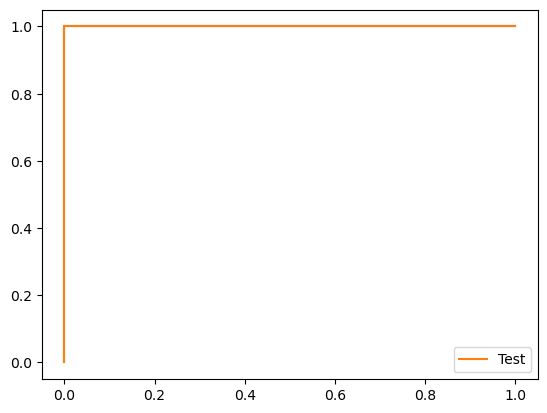

In [159]:
plt.plot(fpr_train, tpr_train)
plt.plot(fpr_test, tpr_test, label = 'Test')
plt.legend()

In [107]:
thr[np.argmax(tpr_test - fpr_test)]

inf

In [108]:
helpers.print_scores(y_test, np.where(y_test_pred >= thr[np.argmax(tpr_test - fpr_test)], 1, 0))

F1: 0.000
Accuracy: 0.526
Precision: 0.000
ROC AUC: 0.500
Recall: 0.000


d:\Anaconda\envs\ai-env-torch\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [68]:
xgbc.feature_importances_

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)